<a href="https://colab.research.google.com/github/bobohope/bdc_summer_2023/blob/main/Conditional_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN for species coexistance pattern

**Description:** Training a GAN conditioned on extra variables

Generative Adversarial Networks (GANs) let us generate novel image data, video data,
or audio data from a random input. Typically, the random input is sampled
from a normal distribution, before going through a series of transformations that turn
it into something plausible (image, video, audio, etc.).

However, a simple [DCGAN](https://arxiv.org/abs/1511.06434) doesn't let us control
the appearance (e.g. class) of the samples we're generating.
To be able to control what we generate, we need to _condition_ the GAN output
on a semantic input.


Following are the references used for developing this example:

* [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)
* [Lecture on Conditional Generation from Coursera](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/conditional-generation-inputs-2OPrG)

If you need a refresher on GANs, you can refer to the "Generative adversarial networks"
section of
[this resource](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-12/r-3/232).

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

In [3]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## Imports

In [16]:
import pandas as pd
import numpy as np
import os
import glob
import shutil

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio

## Constants and hyperparameters

In [6]:
batch_size = 64
num_channels = 1
image_size = 16
latent_dim = 128
hold_out_frac = 0.1
positive_threshold = 0.5

## Loading dataset and preprocessing

In [7]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [8]:
google_drive_dir = "/content/gdrive/My Drive/gan_data/"
# !mkdir "$google_drive_dir"

In [9]:
training_data = pd.read_csv(google_drive_dir+'final_data_20231115.csv', sep='\t')

In [10]:
training_data

,Unnamed: 0,lat_lon,month,year,snom,csnow,air,vis,apcp,evap,...,Bucephala albeola,Lophodytes cucullatus,Mareca strepera,Mareca americana,Aythya collaris,Cygnus olor,Mergus serrator,Spatula clypeata,Mergus merganser,Spatula discors
0,0,"(25.21298, -80.80556)",1,2022,0.000000,0.000000,293.15067,18463.783,1.783782,0.243646,...,0,0,1,1,1,0,0,1,0,1
1,1,"(25.21298, -80.80556)",2,2022,0.000000,0.000000,295.28534,17220.467,1.062557,0.304188,...,0,0,0,0,0,0,0,0,0,1
2,2,"(25.21298, -80.80556)",4,2022,0.000000,0.000000,298.49300,18676.670,1.928958,0.348559,...,0,0,0,0,0,0,0,0,0,1
3,3,"(25.21298, -80.80556)",9,2022,0.000000,0.000000,302.05057,17731.424,7.805038,0.406399,...,0,0,0,0,0,0,0,0,0,1
4,4,"(25.21298, -80.80556)",10,2022,0.000000,0.000000,299.10720,18337.787,2.369916,0.311079,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67296,67296,"(72.95542, -84.72343)",6,2022,0.130371,0.183333,276.19928,16246.982,0.947968,0.213672,...,0,0,0,0,0,0,0,0,0,0
67297,67297,"(73.02668, -79.89407)",6,2022,0.312533,0.241667,273.96857,14880.315,1.077916,0.189339,...,0,0,0,0,0,0,1,0,0,0
67298,67298,"(73.83063, -120.6265)",6,2022,0.506478,0.133333,272.50894,9324.483,0.855000,0.018955,...,0,0,0,0,0,0,0,0,0,0
67299,67299,"(74.13185, -119.8663)",6,2022,0.450293,0.145833,272.75400,10686.983,0.921406,0.019043,...,0,0,0,0,0,0,0,0,0,0


In [11]:
species_picked = ['Branta canadensis',
                  'Anas platyrhynchos',
                  'Anas crecca',
                  'Anas rubripes',
                  'Bucephala clangula',
                  'Aix sponsa',
                  'Bucephala albeola',
                  'Lophodytes cucullatus',
                  'Mareca strepera',
                  'Mareca americana',
                  'Aythya collaris',
                  'Cygnus olor',
                  'Mergus serrator',
                  'Spatula clypeata',
                  'Mergus merganser',
                  'Spatula discors',
                 ]
# conditional_features = [
#     'snom', 'csnow', 'air', 'vis', 'apcp', 'evap',
#        'crain', 'uwnd', 'vwnd', 'weasd', 'ccond', 'mstav', 'wspd', 'cicep',
#        'prate', 'lftx4', 'rhum', 'snowc', 'tcdc', 'albedo', 'veg', 'snod',
#        'hlcy', 'cfrzr'
# ]
conditional_features = [
'prate', 'lftx4', 'rhum', 'snowc', 'tcdc', 'albedo', 'veg', 'snod',
        'hlcy', 'cfrzr'
]
num_conditional_features = len(conditional_features) # environmental variables


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(training_data, test_size=hold_out_frac, random_state=42)

In [13]:
species = X_train[species_picked].values
# construct 2d image using species prestentation data
# dimension for each patch is [16,16]
n_tile = 16
species_2D = np.asarray([np.transpose(np.tile(item, (n_tile,1))) for item in species])


In [19]:
dir_name = google_drive_dir+'images_for_GAN_training/'
# try:
#     shutil.rmtree(dir_name)
# except OSError as e:
#   pass

print(f'Creating directories ...')
# os.mkdir(dir_name)

dir_name=os.path.join(dir_name,'real_patches/')
IMAGE_PATH= dir_name

if not os.path.exists(dir_name):
      os.mkdir(dir_name)

n_patches = species_2D.shape[0]



Creating directories ...


In [22]:
# # # save images
# print(f'... saving Images ...')
# for j in range(n_patches):
#     array = species_2D[j,:,:]
#     array = (array * 255).astype(np.uint8)

#     Image.fromarray(array).convert('L').save(os.path.join(dir_name,str(j)+'.png'))

# print('... a total of {} images saved at directory {}'.format(n_patches,dir_name))

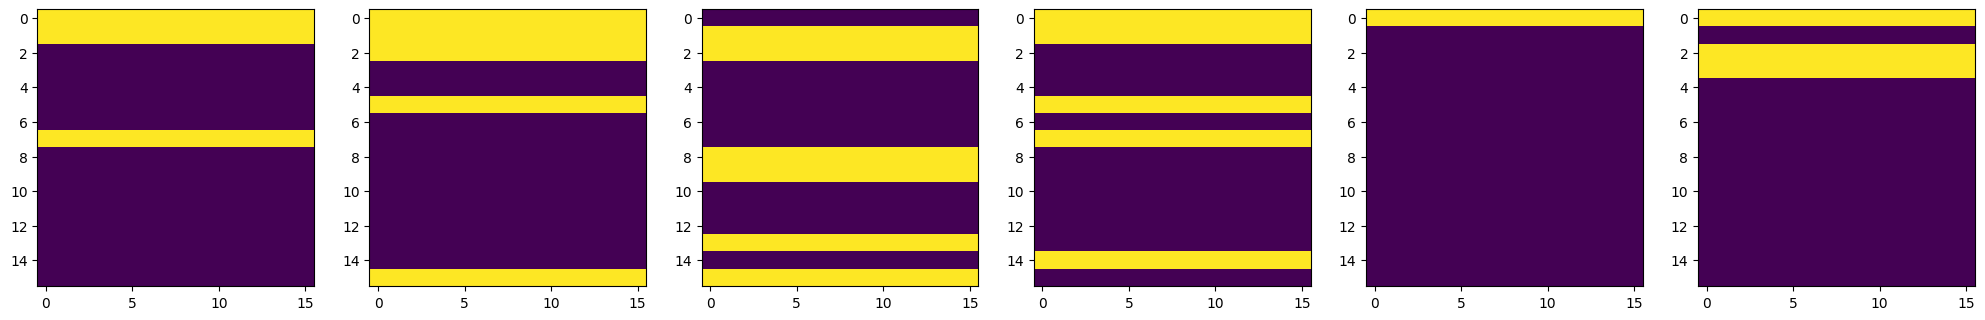

<Figure size 640x480 with 0 Axes>

In [23]:
# plot images
from PIL import Image
from matplotlib import pyplot as plt
import random
fig, ax = plt.subplots(1, 6, figsize=(25,100))

for x in range(0,6) :
  im = Image.open(os.path.join(dir_name,str(random.randint(0,400))+'.png'))
  ax[x].imshow(im)

plt.show()
plt.tight_layout()

In [24]:
# normalize conditional input

conditional_input = X_train[conditional_features].values
mean = conditional_input.mean(axis=0)
std = conditional_input.std(axis=0)

conditional_input_std = (conditional_input - mean) / std

conditional_input_std = np.float32(conditional_input_std)


In [25]:
conditional_input_std

array([[-0.46910113,  0.10261691, -0.90324706, ..., -0.2446004 ,
        -0.29286382, -0.25522688],
       [ 4.0897665 , -0.26095766,  1.393767  , ..., -0.23752011,
        -0.44377932, -0.25522688],
       [-1.0750395 , -0.8574995 , -1.340351  , ..., -0.2446004 ,
        -0.9194975 , -0.25522688],
       ...,
       [-0.8688636 , -0.13979453, -0.0354595 , ...,  0.02223363,
         0.42591736, -0.25522688],
       [ 4.9617157 , -1.7911695 ,  0.8956647 , ..., -0.2446004 ,
        -1.5153422 , -0.25522688],
       [-0.5660201 ,  0.4773921 ,  0.21861863, ..., -0.24459659,
        -0.5324463 , -0.25522688]], dtype=float32)

In [26]:
species_reshape = np.reshape(species_2D, (-1, 16, 16, 1))
dataset = tf.data.Dataset.from_tensor_slices((species_reshape, conditional_input_std))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

## Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed
dimension) from a normal distribution. In our case, we also need to account
for the conditional variables. We will have to add the number of conditional variables to
the input channels of the generator (noise input) as well as the discriminator
(generated image input).

In [28]:
generator_in_channels = latent_dim + num_conditional_features
discriminator_in_channels = num_channels + num_conditional_features
print("generator_channels: ", generator_in_channels)
print("discriminator channels: ", discriminator_in_channels)

generator_channels:  138
discriminator channels:  11


## Creating the discriminator and generator

The model definitions (`discriminator`, `generator`, and `ConditionalGAN`) have been
adapted from [this example](https://keras.io/guides/customizing_what_happens_in_fit/).

In [29]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((16, 16, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate latent_dim + num_classes coefficients to reshape into a
        # 7x7x(latent_dim + num_classes) map.
        layers.Dense(4 * 4 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((4, 4, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (4, 4), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

## Creating a `ConditionalGAN` model

In [30]:

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_conditional_features)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # print(generated_images.get_shape())
        # print(image_one_hot_labels.get_shape())
        # print(real_images.get_shape())
        real_images = tf.cast(real_images, tf.float32)
        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## Training the Conditional GAN

In [31]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)
print("Generator Model Summary")
print(cond_gan.generator.summary())
print("Discriminator Model Summary")
print(cond_gan.discriminator.summary())

cond_gan.fit(dataset, epochs=20)

Generator Model Summary
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2208)              306912    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2208)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 138)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         282752    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                      

In [55]:
# save the gan model

cond_gan.generator.save(google_drive_dir+ 'cond_gan_generator.keras')
cond_gan.save(google_drive_dir+ 'cond_gan.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


## Interpolating between classes with the trained generator

In [32]:
# We first extract the trained generator from our Conditional GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))

def generate_fake(conditional_input):
    conditional_input_repeat = tf.repeat(conditional_input, repeats=num_interpolation)
    conditional_input_repeat = tf.reshape(conditional_input_repeat, [9,10])
    noise_and_conditional_input = tf.concat([interpolation_noise, conditional_input_repeat], 1)
    fake = trained_gen.predict(noise_and_conditional_input)
    return fake




In [33]:
conditional_input = X_test[conditional_features].values[1]
conditional_input_std = np.float32((conditional_input - mean) / std)

Here, we first sample noise from a normal distribution and then we repeat that for
`num_interpolation` times and reshape the result accordingly.
We then distribute it uniformly for `num_interpolation`
with the label identities being present in some proportion.

In [34]:
fake_images = generate_fake(conditional_input_std)

1/1 [==============================] - 0s 242ms/step


In [35]:
# convert image to grey scale
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (16, 16)).numpy().astype(np.uint8)


We can further improve the performance of this model with recipes like
[WGAN-GP](https://keras.io/examples/generative/wgan_gp).
Conditional generation is also widely used in many modern image generation architectures like
[VQ-GANs](https://arxiv.org/abs/2012.09841), [DALL-E](https://openai.com/blog/dall-e/),
etc.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conditional-gan) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conditional-GAN).

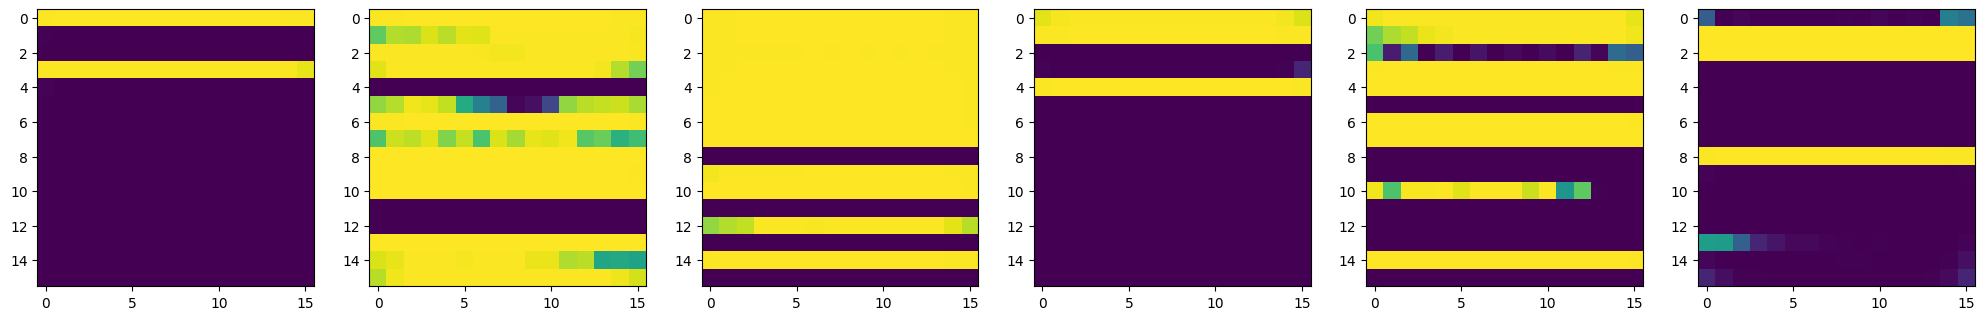

<Figure size 640x480 with 0 Axes>

In [36]:
# from PIL import Image
from matplotlib import pyplot as plt
import random
fig, ax = plt.subplots(1, 6, figsize=(25,100))

for x in range(0,6) :
  # im = Image.open(os.path.join(dir_name,str(random.randint(0,species_2D.shape[0]))+'.png'))
  ax[x].imshow(converted_images[x])

plt.show()
plt.tight_layout()